In [1]:
import pandas as pd
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="whitegrid")

In [2]:
current_path = os.getcwd()
base_path = os.path.dirname(os.path.dirname(current_path))
filepath = os.path.join(base_path, "data", "raw",'music_data.csv')
filepath_bis = os.path.join(base_path, "data", "app",'2025-03-22T16-11_export.csv')

In [3]:
data = load_data(filepath)
data_bis = load_data(filepath_bis)
data.head()

Données chargées avec succès.
Données chargées avec succès.


,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [4]:
data.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

In [5]:
variables_selected = ['loudness', 'tempo', 'energy', 'acousticness','valence']  # par exemple

for var in variables_selected:
    # conversion en numérique
    data[var] = pd.to_numeric(data[var], errors='coerce')
    print(f"{var} : min = {data[var].min()}, max = {data[var].max()}")

loudness : min = -47.04600000000001, max = 3.744
tempo : min = 34.347, max = 220.276
energy : min = 0.000792, max = 0.999
acousticness : min = 0.0, max = 0.996
valence : min = 0.0, max = 0.992


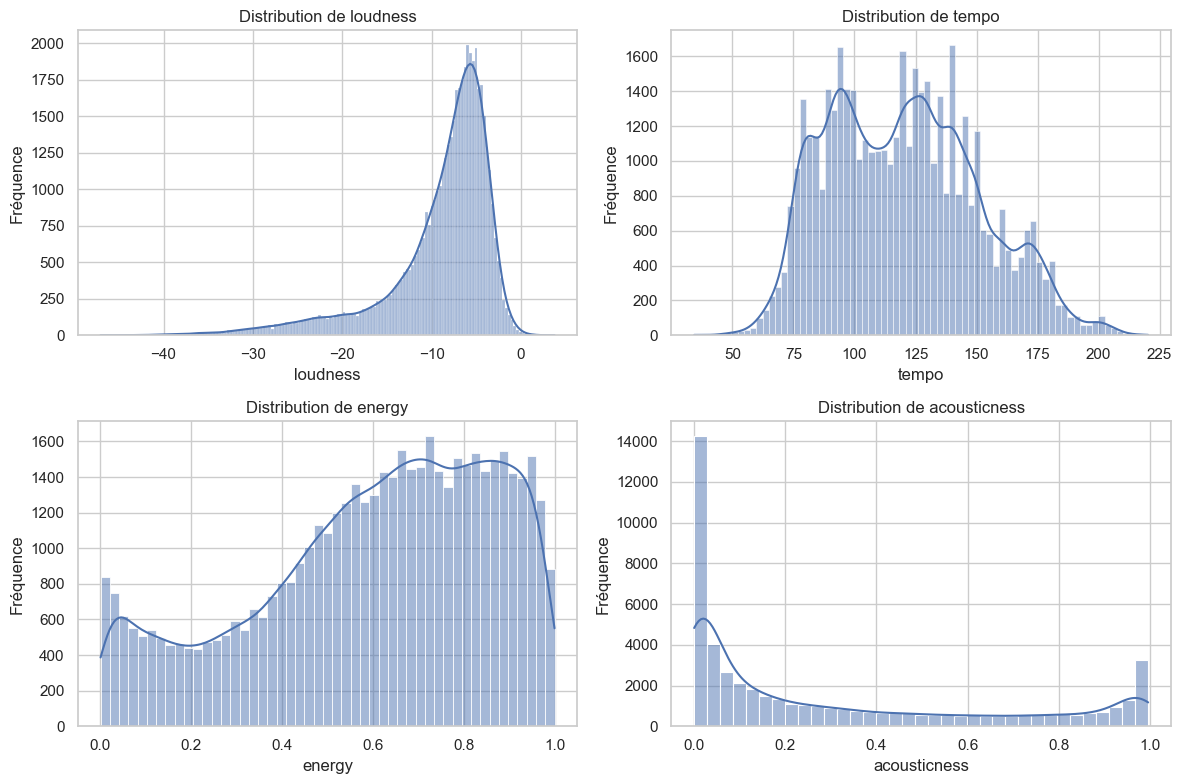

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, col in enumerate(variables_selected[:4]): 
    sns.histplot(data[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

> Selectionons des plages de valeurs avec une grande frequence, pour facilité la recherche de musiques

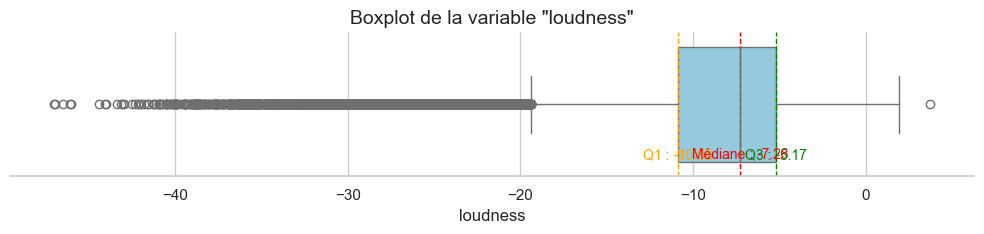

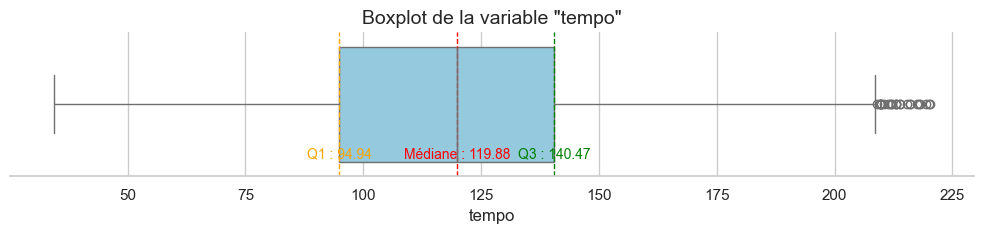

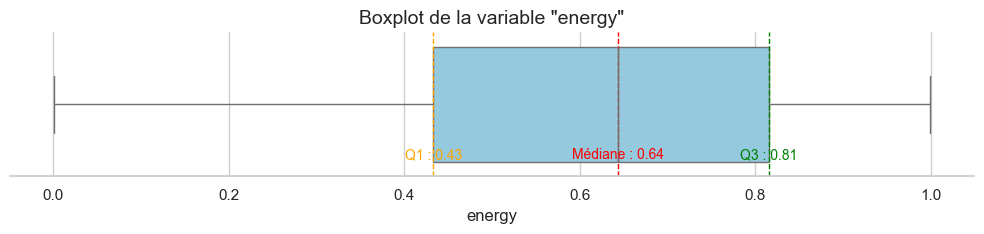

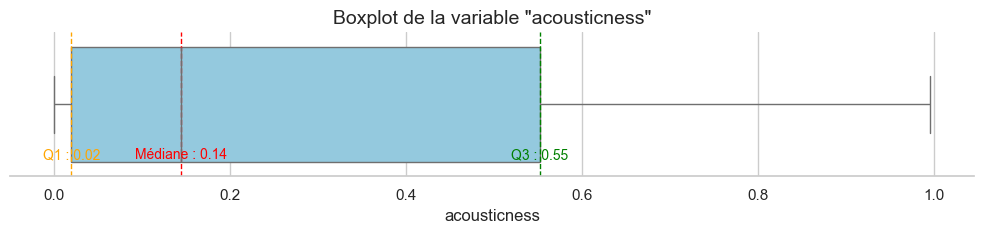

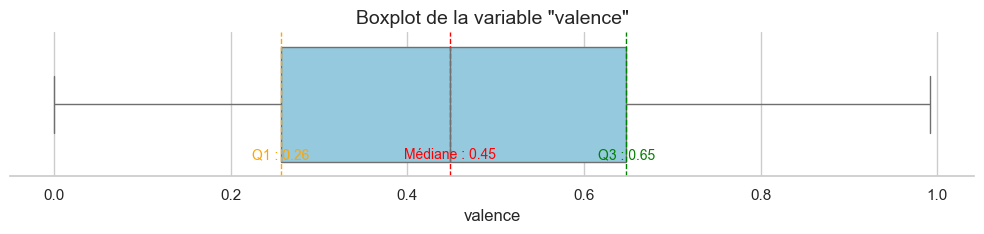

In [7]:
for col in variables_selected:
    plt.figure(figsize=(10, 2.5))
    values = data[col].dropna()

    ax = sns.boxplot(x=values, color='skyblue')
    plt.title(f'Boxplot de la variable "{col}"', fontsize=14)
    plt.xlabel(col, fontsize=12)
    sns.despine(left=True)

    # Calcul des quantiles
    q1 = values.quantile(0.25)
    median = values.quantile(0.5)
    q3 = values.quantile(0.75)

    for q, label, color in zip([q1, median, q3], ['Q1', 'Médiane', 'Q3'], ['orange', 'red', 'green']):
        plt.axvline(q, linestyle='--', color=color, linewidth=1)
        plt.text(q, 0.1, f'{label} : {q:.2f}', color=color, fontsize=10,
                 ha='center', va='bottom', transform=plt.gca().get_xaxis_transform())


    plt.tight_layout()
    plt.show()

### Sélection des variables pour le plan d'expérience

On choisi de conserver uniquement les variables numériques **continues**, et pertinentes :


| Variable       | Min        | Max     | Interprétation |
|----------------|------------|---------|----------------|
| `loudness`     | -11     | -5   | Volume moyen du morceau (en dB) |
| `tempo`        | 94     | 140  | Vitesse de la musique (en BPM) |
| `energy`       | 0     | 1   | Intensité perçue de la musique |
| `acousticness` | 0        | 0.5   | Probabilité que le morceau soit acoustique |
| `valence`      | 0        | 0.6   | Positivité émotionnelle du morceau |

Ces **5** variables serviront de **paramétres**, avec pour valeurs maximales et maxmales les quantiles Q1 et Q3.

**5 niveaux** par paramètre semblent suffisants pour ne pas trop complexifier le traitement des données.


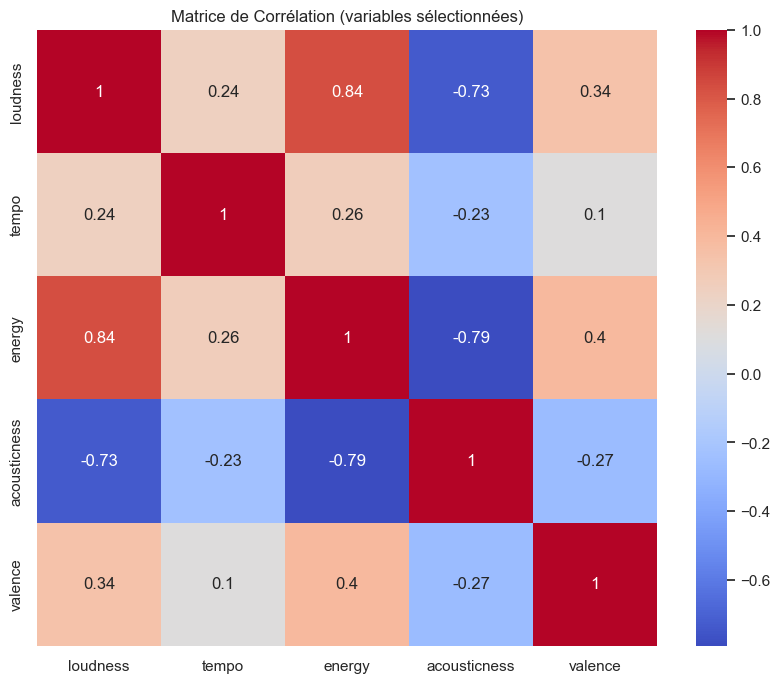

In [8]:
selected_data = data[variables_selected]

plt.figure(figsize=(10, 8))
sns.heatmap(selected_data.corr(), annot=True, cmap='coolwarm')
plt.title("Matrice de Corrélation (variables sélectionnées)")
plt.show()

On remarque que `loudness` et `energy` sont fortement corrélées. Il est donc peu probable de trouver, dans le dataset, une musique avec une valeur minimale pour l’une et maximale pour l’autre. On pourrait envisager de filtrer ce type de cas, mais cela risquerait d’introduire de la confusion entre ces deux variables. Ainsi, pour éviter la redondance, on choisit de supprimer l’une des deux : ici, energy.

---
#### Determiner à quoi correspond chaques niveaux 

In [9]:
data['loudness'] = data['loudness'].where((data['loudness'] >= -11) & (data['loudness'] <= -5), np.nan)
data['tempo'] = data['tempo'].where((data['tempo'] >= 94)  & (data['tempo'] <= 140), np.nan)
#data['energy'] = data['energy'].where((data['energy'] >= 0) & (data['energy'] <= 1), np.nan)
data['acousticness'] = data['acousticness'].where((data['acousticness'] >= 0) & (data['acousticness'] <= 0.5), np.nan)
data['valence'] = data['valence'].where((data['valence'] >= 0) & (data['valence'] <= 0.6), np.nan)

In [10]:
loudness_niveau = pd.cut(data['loudness'], bins=5, labels=[-1, -0.5, 0, 0.5, 1])
tempo_niveau = pd.cut(data['tempo'], bins=5, labels=[-1, -0.5, 0, 0.5, 1])
#energy_niveau = pd.cut(data['energy'], bins=5, labels=[-1, -0.5, 0, 0.5, 1])
acousticness_niveau = pd.cut(data['acousticness'], bins=5, labels=[-1, -0.5, 0, 0.5, 1])
valence_niveau = pd.cut(data['valence'], bins=5, labels=[-1, -0.5, 0, 0.5, 1])
data['loudness_niveau'] = loudness_niveau
data['tempo_niveau'] = tempo_niveau
#data['energy_niveau'] = energy_niveau
data['acousticness_niveau'] = acousticness_niveau
data['valence_niveau'] = valence_niveau

> **De cette manière, on ne garde que les valeurs comprises entre les quantiles Q1 et Q3, que l’on divise ensuite en cinq niveaux, sur nos quatre paramètres.**

#### Trouvons les caracteristiques des musiques à extraire :

| Facteur | Variable         |
|---------|------------------|
| 1       | loudness         |
| 2       | tempo            |
| 3       | acousticness           |
| 4       | valence      |


In [11]:
rename_dict_inverse = {
    'Facteur 1': 'loudness',
    'Facteur 2': 'tempo',
    'Facteur 3': 'acousticness',
    'Facteur 4': 'valence'
}

data_bis = data_bis.rename(columns=rename_dict_inverse)
data_bis

,loudness,tempo,acousticness,valence,Résultat
0,0.0,1.0,-0.5,0.5,NaN
1,0.5,0.5,0.5,-0.5,NaN
2,-0.5,-1.0,0.0,0.0,NaN
3,0.0,0.5,-1.0,0.0,NaN
4,-1.0,-0.5,0.0,-0.5,NaN
5,0.5,-0.5,1.0,0.5,NaN


In [12]:
data_selection_0 = data[(data['loudness_niveau'] == 0) & (data['tempo_niveau'] == 1)& (data['acousticness_niveau'] == -0.5)& (data['valence_niveau'] == 0.5)]
data_selection_1 = data[(data['loudness_niveau'] == 0.5) & (data['tempo_niveau'] == 0.5)& (data['acousticness_niveau'] == 0.5)& (data['valence_niveau'] == -0.5)]
data_selection_2 = data[(data['loudness_niveau'] == -0.5) & (data['tempo_niveau'] == -1)& (data['acousticness_niveau'] == 0)& (data['valence_niveau'] == 0)]
data_selection_3 = data[(data['loudness_niveau'] == 0) & (data['tempo_niveau'] == 0.5)& (data['acousticness_niveau'] == -1)& (data['valence_niveau'] == 0)]
data_selection_4 = data[(data['loudness_niveau'] == -1) & (data['tempo_niveau'] == -0.5)& (data['acousticness_niveau'] == 0)& (data['valence_niveau'] == -0.5)]
data_selection_5 = data[(data['loudness_niveau'] == 0.5) & (data['tempo_niveau'] == -0.5)& (data['acousticness_niveau'] == 1)& (data['valence_niveau'] == 0.5)]

In [13]:
data_selection_0

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
11476,73140.0,Warren Hill,September Morning,42.0,0.111,0.614,333147.0,0.540,0.174000,C,...,Minor,0.0304,135.965,4-Apr,0.432,Jazz,0.0,1.0,-0.5,0.5
17507,72610.0,Lifehouse,You And Me,73.0,0.103,0.456,195493.0,0.432,0.000000,G,...,Major,0.0266,139.909,3-Apr,0.391,Alternative,0.0,1.0,-0.5,0.5
23516,89404.0,Confederate Railroad,Jesus And Mama,38.0,0.121,0.621,202573.0,0.573,0.000222,B,...,Major,0.0259,136.580,4-Apr,0.469,Country,0.0,1.0,-0.5,0.5
27078,61511.0,mansionz,STFU,72.0,0.160,0.824,230878.0,0.470,0.000000,C#,...,Minor,0.1760,134.922,4-Apr,0.437,Rap,0.0,1.0,-0.5,0.5
28918,58662.0,Lil Yachty,Nolia (feat. Kevin Gates),54.0,0.144,0.813,202105.0,0.483,0.000000,D#,...,Minor,0.4570,132.954,4-Apr,0.398,Rap,0.0,1.0,-0.5,0.5
39700,28964.0,Maná,Vivir Sin Aire,62.0,0.105,0.670,291493.0,0.528,0.000103,G,...,Major,0.0261,132.310,4-Apr,0.384,Rock,0.0,1.0,-0.5,0.5
45656,34879.0,empty_field,Lie 2 Me,53.0,0.172,0.642,198840.0,0.444,0.000000,G#,...,Major,0.3440,139.953,4-Apr,0.456,Hip-Hop,0.0,1.0,-0.5,0.5


In [14]:
data_selection_1

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
2668,86739.0,KRANE,Outside,31.0,0.302,0.492,232131.0,0.526,0.000047,A,...,Minor,0.0440,122.178,4-Apr,0.163,Electronic,0.5,0.5,0.5,-0.5
16247,59959.0,Big Daddy Weave,Redeemed,54.0,0.374,0.329,276187.0,0.509,0.000000,B,...,Major,0.0333,127.119,3-Apr,0.227,Alternative,0.5,0.5,0.5,-0.5
22395,79283.0,Reba McEntire,That's When I Knew,34.0,0.359,0.548,243400.0,0.538,0.000023,F#,...,Major,0.0274,127.939,4-Apr,0.209,Country,0.5,0.5,0.5,-0.5
24882,53341.0,Reba McEntire,You Lie - Single Version,36.0,0.386,0.577,238560.0,0.391,0.000000,A#,...,Major,0.0275,128.804,3-Apr,0.224,Country,0.5,0.5,0.5,-0.5
26881,72275.0,Jaden Smith,Ninety,62.0,0.384,0.398,468168.0,0.690,0.000437,C#,...,Minor,0.0631,129.904,4-Apr,0.174,Rap,0.5,0.5,0.5,-0.5
27098,30948.0,Kanye West,FML,70.0,0.313,0.667,236120.0,0.423,0.000000,A,...,Minor,0.0822,125.116,4-Apr,0.156,Rap,0.5,0.5,0.5,-0.5
45472,61783.0,De La Ghetto,Ojalá (feat. Darell),59.0,0.372,0.640,304733.0,0.529,0.000000,C,...,Minor,0.0893,128.101,4-Apr,0.177,Hip-Hop,0.5,0.5,0.5,-0.5
49034,35151.0,Jaden Smith,Ninety,62.0,0.384,0.398,468168.0,0.690,0.000437,C#,...,Minor,0.0631,129.904,4-Apr,0.174,Hip-Hop,0.5,0.5,0.5,-0.5
49953,67517.0,ScHoolboy Q,Hell Of A Night,63.0,0.377,0.652,272453.0,0.836,0.000000,D,...,Minor,0.1530,123.946,4-Apr,0.162,Hip-Hop,0.5,0.5,0.5,-0.5


In [15]:
data_selection_2

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
1942,76478.0,empty_field,american dream - electric lady sessions,47.0,0.272,0.561,363520.0,0.588,0.00312,C,...,Major,0.0266,102.720,3-Apr,0.285,Electronic,-0.5,-1.0,0.0,0.0
9494,49377.0,Nobuo Uematsu,Swing De Chocobo (Final Fantasy Series),34.0,0.260,0.428,272800.0,0.472,0.00564,A,...,Minor,0.0305,94.331,4-Apr,0.358,Anime,-0.5,-1.0,0.0,0.0
34444,90870.0,Gary Moore,Empty Rooms,44.0,0.204,0.532,257440.0,0.476,0.00000,D,...,Minor,0.0251,98.180,4-Apr,0.319,Blues,-0.5,-1.0,0.0,0.0


In [16]:
data_selection_3

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
891,23076.0,The Stone Roses,This Is the One - Remastered,53.0,0.001360,0.247,299320.0,0.784,0.036300,A,...,Major,0.0514,127.001,4-Apr,0.346,Electronic,0.0,0.5,-1.0,0.0
1106,46094.0,Sasha,Out Of Time,34.0,0.001870,0.685,581029.0,0.901,0.347000,C#,...,Major,0.0453,123.007,4-Apr,0.301,Electronic,0.0,0.5,-1.0,0.0
1535,82026.0,The Crystal Method,The Winner,28.0,0.002020,0.591,311707.0,0.935,0.793000,C#,...,Major,0.0444,127.000,4-Apr,0.338,Electronic,0.0,0.5,-1.0,0.0
1690,22017.0,Dirty Vegas,Days Go By,48.0,0.049900,0.786,432147.0,0.853,0.087200,A,...,Minor,0.0688,126.990,4-Apr,0.309,Electronic,0.0,0.5,-1.0,0.0
2067,25198.0,Róisín Murphy,Plaything,44.0,0.002220,0.819,363370.0,0.549,0.014200,C#,...,Major,0.0442,125.015,4-Apr,0.319,Electronic,0.0,0.5,-1.0,0.0
2192,83564.0,Destructo,Bust Them Cheeks (feat. Too $hort),27.0,0.025500,0.874,252029.0,0.629,0.001030,D,...,Major,0.0592,123.977,4-Apr,0.358,Electronic,0.0,0.5,-1.0,0.0
2369,83952.0,empty_field,Give It Up,29.0,0.008640,0.808,346452.0,0.683,0.425000,F#,...,Major,0.1880,124.008,4-Apr,0.332,Electronic,0.0,0.5,-1.0,0.0
2489,42500.0,Volen Sentir,Arrival - Original Mix,32.0,0.000297,0.792,447916.0,0.684,0.866000,G,...,Major,0.0460,123.014,4-Apr,0.345,Electronic,0.0,0.5,-1.0,0.0
2895,43579.0,Lone,Pulsar,37.0,0.000167,0.409,460222.0,0.872,0.878000,G,...,Major,0.0875,125.966,4-Apr,0.351,Electronic,0.0,0.5,-1.0,0.0
3249,48317.0,Digitalism,Utopia,30.0,0.001650,0.625,397800.0,0.657,0.866000,A#,...,Minor,0.0307,121.989,4-Apr,0.308,Electronic,0.0,0.5,-1.0,0.0


In [17]:
data_selection_4

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
221,80016.0,Be Svendsen,Nabia,48.0,0.252,0.879,537164.0,0.777,0.84900,A#,...,Minor,0.0559,110.003,4-Apr,0.198,Electronic,-1.0,-0.5,0.0,-0.5
22835,20946.0,Alan Jackson,Angels And Alcohol,44.0,0.244,0.678,213013.0,0.409,0.00122,A#,...,Major,0.0267,104.007,4-Apr,0.203,Country,-1.0,-0.5,0.0,-0.5


In [18]:
data_selection_5

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,obtained_date,valence,music_genre,loudness_niveau,tempo_niveau,acousticness_niveau,valence_niveau
21094,21234.0,Dixie Chicks,Never Say Die,39.0,0.447,0.672,237162.0,0.487,0.000000,C,...,Major,0.0252,105.582,4-Apr,0.380,Country,0.5,-0.5,1.0,0.5
24964,71409.0,Jordan Brooker,You Are,56.0,0.435,0.571,213573.0,0.611,0.000148,F,...,Major,0.0330,109.939,4-Apr,0.380,Country,0.5,-0.5,1.0,0.5
33962,85570.0,Leon Bridges,Coming Home,64.0,0.461,0.427,206387.0,0.465,0.000055,F#,...,Major,0.0291,112.137,3-Apr,0.458,Blues,0.5,-0.5,1.0,0.5
34397,25010.0,Anderson East,All I'll Ever Need,35.0,0.480,0.642,198667.0,0.509,0.000006,A,...,Major,0.0269,103.212,3-Apr,0.432,Blues,0.5,-0.5,1.0,0.5
37323,77079.0,empty_field,Wasted Time,53.0,0.408,0.602,300973.0,0.603,0.001880,A,...,Major,0.0328,112.021,4-Apr,0.454,Rock,0.5,-0.5,1.0,0.5
